In [11]:
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()


import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.preprocessing import minmax_scale
from sklearn.metrics import confusion_matrix

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin

In [13]:
train = pd.read_csv("../data/input_data/application_train.csv", index_col="SK_ID_CURR")#, nrows=100000)
test = pd.read_csv("../data/input_data/application_test.csv", index_col="SK_ID_CURR")

X_train = train.drop("TARGET", axis=1)
X_test = test
y_train = train["TARGET"]
y_free = y_train

default = (y_train == 1)
X_train_def = X_train[default]

In [14]:
X_test.shape

(48744, 120)

In [15]:
y_train.mean()

0.08072881945686496

In [16]:
y_free = y_train

In [17]:
type(y_free)

pandas.core.series.Series

In [18]:
X_train.shape

(307511, 120)

In [19]:
variables = pd.read_csv("../data/input_data/HomeCredit_columns_description.csv")

In [20]:
variables.head()

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


In [21]:
list(variables.loc[(variables["Table"] == "application_{train|test}.csv"), "Row"])

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_A

In [22]:
documents = ['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']

In [23]:
loan = ['NAME_CONTRACT_TYPE', 'AMT_GOODS_PRICE', 'AMT_ANNUITY', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       ]

In [24]:
main = ['SK_ID_CURR', 'CODE_GENDER', 'FLAG_OWN_CAR',
        'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
        'NAME_EDUCATION_TYPE', 'NAME_HOUSING_TYPE',
        'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
        'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL',
        'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
        'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 
        'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
        'EXT_SOURCE_3']

In [25]:
family = ['CNT_CHILDREN', 'NAME_FAMILY_STATUS', 'CNT_FAM_MEMBERS']

In [26]:
geographicals = ['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
                 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
                'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
                 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY']

# Main Set (ms)

In [27]:
#Custom Transformer that extracts columns passed as argument to its constructor 
class RedefineDTypes(BaseEstimator, TransformerMixin):
    #Class Constructor 
    def __init__(self):
        pass
    
    #Return self nothing else to do here    
    def fit(self, X, y = None):
        #Detect the type
        cat_feat = []
        cont_feat = []
        bin_feat = []
        
        for column in X :
            
            name = column
            name_type = X[column].dtype
            if name_type == "object" : 
                cat_feat.append(name)
                #print("category", name, name_type)
            
            elif (name_type == "int64") | (name_type == "float64") : 
                n_modalities = X[column].nunique()
                if n_modalities == 2 : 
                    bin_feat.append(name)
                    #print("binary", name, n_modalities)

                else : 
                    cont_feat.append(name)
                    #print("continuous", name, n_modalities)
            
            else : 
                print("unknown type", name, name_type)
            
        self.cat_feat = cat_feat
        self.cont_feat = cont_feat
        self.bin_feat = bin_feat
        
        #print(len(cat_feat+cont_feat+bin_feat))
        
        return self
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        X_out = X.copy()
        X_out[self.cat_feat] = X[self.cat_feat].astype("category")
        X_out[self.bin_feat] = X[self.bin_feat].replace([True, False], [1,0]).astype(float)
        #X_out[self.bin_feat] = X[self.bin_feat].astype("bool")
        X_out[self.cont_feat] = X[self.cont_feat].astype("float")
        
        return X_out

In [28]:
rdt = RedefineDTypes()

In [29]:
X_train_rdt = rdt.fit(X_train, y_train).transform(X_train)

In [30]:
class Train_Test_Processor(BaseEstimator, TransformerMixin) : 
    def __init__(self) : 
        pass
    
    def fit(self, X, y=None) : 
        return self
    
    def transform(self, X, y=None) : 
        nan_as_category = False
        
        df = X.copy()
        df = df[df['CODE_GENDER'] != 'XNA']
        
        for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
            df[bin_feature], uniques = pd.factorize(df[bin_feature])

        # NaN values for DAYS_EMPLOYED: 365.243 -> nan
        df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
        
        # Some simple new features (percentages)
        df['DAYS_EMPLOYED'] = -df['DAYS_EMPLOYED']
        df['DAYS_BIRTH'] = -df['DAYS_BIRTH']
        df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
        df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
        df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
        df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
        df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
        
        return df

In [31]:
ttp = Train_Test_Processor()

In [32]:
ms = ttp.fit(X_train_rdt).transform(X_train_rdt)

In [33]:
ms.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,Cash loans,0,0,0,0.0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,...,0.0,0.0,0.0,0.0,1.0,0.067329,0.498036,202500.0,0.121978,0.060749
100003,Cash loans,1,0,1,0.0,270000.0,1293502.5,35698.5,1129500.0,Family,...,0.0,0.0,0.0,0.0,0.0,0.070862,0.208736,135000.0,0.132217,0.027598
100004,Revolving loans,0,1,0,0.0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,...,0.0,0.0,0.0,0.0,0.0,0.011814,0.500000,67500.0,0.100000,0.050000
100006,Cash loans,1,0,0,0.0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,0.159905,0.431748,67500.0,0.219900,0.094941
100007,Cash loans,0,0,0,0.0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,...,0.0,0.0,0.0,0.0,0.0,0.152418,0.236842,121500.0,0.179963,0.042623


In [34]:
ms.to_pickle('../data/output_data/ms')
ms.to_csv('../data/output_data/ms.csv')

# Other Sets

In [35]:
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

## Bureau And Balance (bb)

In [36]:
bureau = pd.read_csv('../data/input_data/bureau.csv')
bb = pd.read_csv('../data/input_data/bureau_balance.csv')

In [37]:
bb.shape

(27299925, 3)

In [38]:
bureau.shape

(1716428, 17)

In [39]:
class Bureau_and_balance(BaseEstimator, TransformerMixin) :
    def __init__(self, bureau_data, bb_data) : 
        #Instead of Loading data on each transform step, i'd rather load in outside,
        #integrate it in the object attributes and then select it.
        self.bureau = bureau_data
        self.bb = bb_data
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None) :
        #Read the whole set
        bureau = self.bureau
        bb = self.bb
        
        #Perhaps the MainSet was computed only on a few raw. So lets no aggregate every
        #Instance if it will not be usefull later. Extract needed index, and aggregate those :
        bureau_reduced = bureau[bureau['SK_ID_CURR'].isin(X.index)]
        skid_bureau_valid = bureau_reduced["SK_ID_BUREAU"].unique()
        
        #Select Bureau ID matching with SK_ID_CURR
        bb_reduced = bb[bb['SK_ID_BUREAU'].isin(skid_bureau_valid)]
        
        def bureau_and_balance(bureau_data, bb_data):
            bb = bb_data
            bureau = bureau_data
            
            bb, bb_cat = one_hot_encoder(bb)
            bureau, bureau_cat = one_hot_encoder(bureau)

            # Bureau balance: Perform aggregations and merge with bureau.csv
            bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
            for col in bb_cat:
                bb_aggregations[col] = ['mean']
            bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
            bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
            bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
            bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
            del bb, bb_agg
            gc.collect()

            # Bureau and bureau_balance numeric features
            num_aggregations = {
                'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
                'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
                'DAYS_CREDIT_UPDATE': ['mean'],
                'CREDIT_DAY_OVERDUE': ['max', 'mean'],
                'AMT_CREDIT_MAX_OVERDUE': ['mean'],
                'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
                'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
                'AMT_CREDIT_SUM_OVERDUE': ['mean'],
                'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
                'AMT_ANNUITY': ['max', 'mean'],
                'CNT_CREDIT_PROLONG': ['sum'],
                'MONTHS_BALANCE_MIN': ['min'],
                'MONTHS_BALANCE_MAX': ['max'],
                'MONTHS_BALANCE_SIZE': ['mean', 'sum']
            }
            # Bureau and bureau_balance categorical features
            cat_aggregations = {}
            for cat in bureau_cat: cat_aggregations[cat] = ['mean']
            for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']

            bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
            bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
            # Bureau: Active credits - using only numerical aggregations
            active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
            active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
            active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
            bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
            del active, active_agg
            gc.collect()
            # Bureau: Closed credits - using only numerical aggregations
            closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
            closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
            closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
            bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')

            bureau_agg = bureau_agg.replace(np.inf, np.nan)
            del closed, closed_agg, bureau
            gc.collect()
            return abs(bureau_agg)
        
        return bureau_and_balance(bureau_reduced, bb_reduced)
        

In [40]:
bab = Bureau_and_balance(bureau_data=bureau, bb_data = bb)

In [41]:
bb_feat = bab.fit(X_train, y_train).transform(X_train)

In [42]:
bb_feat.head(3)

,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,...,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,CLOSED_AMT_ANNUITY_MAX,CLOSED_AMT_ANNUITY_MEAN,CLOSED_CNT_CREDIT_PROLONG_SUM,CLOSED_MONTHS_BALANCE_MIN_MIN,CLOSED_MONTHS_BALANCE_MAX_MAX,CLOSED_MONTHS_BALANCE_SIZE_MEAN,CLOSED_MONTHS_BALANCE_SIZE_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1437.0,103.0,874.00,186150.000000,1072.0,780.0,349.0,499.875,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,47.0,0.0,15.0,90.0
100003,2586.0,606.0,1400.75,827783.583333,2434.0,1216.0,544.5,816.000,0.0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0
100004,1326.0,408.0,867.00,421362.000000,595.0,382.0,488.5,532.000,0.0,0.0,...,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0


## Previous Application (pa)

In [43]:
prev = pd.read_csv('../data/input_data/previous_application.csv')

In [44]:
prev.shape

(1670214, 37)

In [45]:
class Previous_Applications(BaseEstimator, TransformerMixin) :
    def __init__(self, prev_data) : 
        self.prev = prev_data
        
    def fit(self, X, y=None) :
        return self
    
    def transform(self, X, y=None) : 
        prev = self.prev
        prev_reduced = prev[prev["SK_ID_CURR"].isin(X.index)]

        def previous_applications(prev_data):
            
            prev = prev_data
            prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
            # Days 365.243 values -> nan
            prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
            prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
            prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
            prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
            prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
            # Add feature: value ask / value received percentage
            prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
            # Previous applications numeric features
            num_aggregations = {
                'AMT_ANNUITY': ['min', 'max', 'mean'],
                'AMT_APPLICATION': ['min', 'max', 'mean'],
                'AMT_CREDIT': ['min', 'max', 'mean'],
                'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
                'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
                'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
                'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
                'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
                'DAYS_DECISION': ['min', 'max', 'mean'],
                'CNT_PAYMENT': ['mean', 'sum'],
            }
            # Previous applications categorical features
            cat_aggregations = {}
            for cat in cat_cols:
                cat_aggregations[cat] = ['mean']

            prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
            prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
            # Previous Applications: Approved Applications - only numerical features
            approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
            approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
            approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
            prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
            # Previous Applications: Refused Applications - only numerical features
            refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
            refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
            refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
            prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')

            prev_agg = prev_agg.replace(np.inf, np.nan)

            del refused, refused_agg, approved, approved_agg, prev
            gc.collect()
            return prev_agg
        
        return previous_applications(prev_reduced)

In [46]:
pa = Previous_Applications(prev_data=prev)

In [47]:
pa_feat = pa.fit(X_train, y_train).transform(X_train)

In [48]:
pa_feat.head()

,PREV_AMT_ANNUITY_MIN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_MEAN,PREV_AMT_CREDIT_MIN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MEAN,PREV_APP_CREDIT_PERC_MIN,...,REFUSED_HOUR_APPR_PROCESS_START_MAX,REFUSED_HOUR_APPR_PROCESS_START_MEAN,REFUSED_RATE_DOWN_PAYMENT_MIN,REFUSED_RATE_DOWN_PAYMENT_MAX,REFUSED_RATE_DOWN_PAYMENT_MEAN,REFUSED_DAYS_DECISION_MIN,REFUSED_DAYS_DECISION_MAX,REFUSED_DAYS_DECISION_MEAN,REFUSED_CNT_PAYMENT_MEAN,REFUSED_CNT_PAYMENT_SUM
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,9251.775,9251.775,9251.775,179055.0,179055.0,179055.00,179055.0,179055.0,179055.00,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100003,6737.310,98356.995,56553.990,68809.5,900000.0,435436.50,68053.5,1035882.0,484191.00,0.868825,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100004,5357.250,5357.250,5357.250,24282.0,24282.0,24282.00,20106.0,20106.0,20106.00,1.207699,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100006,2482.920,39954.510,23651.175,0.0,688500.0,272203.26,0.0,906615.0,291695.50,0.759418,...,15.0,15.0,NaN,NaN,NaN,-181.0,-181.0,-181.0,48.0,48.0
100007,1834.290,22678.785,12278.805,17176.5,247500.0,150530.25,14616.0,284400.0,166638.75,0.791139,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
len(list(pa_feat.columns))

248

## Point of Sale cash balance (pos)

In [50]:
 pos = pd.read_csv('../data/input_data/POS_CASH_balance.csv')

In [51]:
pos.shape

(10001358, 8)

In [52]:
class Pos_Cash_Balance(BaseEstimator, TransformerMixin) :
    def __init__(self, pos_data) : 
        self.pos = pos_data
        
    def fit(self, X, y=None) :
        return self
    
    def transform(self, X, y=None) : 
        pos = self.pos
        pos_reduced = pos[pos["SK_ID_CURR"].isin(X.index)]

        def pos_cash(pos_data):
            pos = pos_reduced
            pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
            # Features
            aggregations = {
                'MONTHS_BALANCE': ['max', 'mean', 'size'],
                'SK_DPD': ['max', 'mean'],
                'SK_DPD_DEF': ['max', 'mean']
            }
            for cat in cat_cols:
                aggregations[cat] = ['mean']

            pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
            pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
            # Count pos cash accounts
            pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()

            pos_agg = pos_agg.replace(np.inf, np.nan)

            del pos
            gc.collect()
            return pos_agg
    
        return abs(pos_cash(pos_reduced))

In [53]:
pcb = Pos_Cash_Balance(pos_data=pos)

In [54]:
pos_feat = pcb.fit(X_train, y_train).transform(X_train,y_train)

## Installments Payments (ins)

In [55]:
ins = pd.read_csv('../data/input_data/installments_payments.csv')

In [56]:
ins.shape

(13605401, 8)

In [57]:
ins.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [58]:
class Installments_Payments(BaseEstimator, TransformerMixin) :
    def __init__(self, ins_data) : 
        self.ins = ins_data
        
    def fit(self, X, y=None) :
        return self
    
    def transform(self, X, y=None) : 
        ins = self.ins
        ins_reduced = ins[ins["SK_ID_CURR"].isin(X.index)]

        def installments_payments(ins_data):
            ins = ins_data
            ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
            # Percentage and difference paid in each installment (amount paid and installment value)
            ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
            ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
            # Days past due and days before due (no negative values)
            ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
            ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
            ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
            ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
            # Features: Perform aggregations
            aggregations = {
                'NUM_INSTALMENT_VERSION': ['nunique'],
                'DPD': ['max', 'mean', 'sum'],
                'DBD': ['max', 'mean', 'sum'],
                'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
                'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
                'AMT_INSTALMENT': ['max', 'mean', 'sum'],
                'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
                'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
            }
            for cat in cat_cols:
                aggregations[cat] = ['mean']
            ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
            ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
            # Count installments accounts
            ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
            ins_agg = ins_agg.replace(np.inf, np.nan)
            del ins
            gc.collect()
            return ins_agg
        
        return installments_payments(ins_reduced)

In [59]:
ip = Installments_Payments(ins_data = ins)

In [60]:
ins_feat = ip.fit(X_train, y_train).transform(X_train)

## Credit Card Balance (ccb)

In [61]:
ccb = pd.read_csv('../data/input_data/credit_card_balance.csv')

In [62]:
ccb.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [63]:
ccb.shape

(3840312, 23)

In [64]:
class Credit_Card(BaseEstimator, TransformerMixin) :
    def __init__(self, ccb_data) : 
        self.ccb = ccb_data
        
    def fit(self, X, y=None) :
        return self
    
    def transform(self, X, y=None) : 
        ccb = self.ccb
        #print(ccb.columns)
        ccb_reduced = ccb[ccb["SK_ID_CURR"].isin(X.index)]
           
        def credit_card_balance(ccb_data):
            ccb = ccb_data
            ccb, cat_cols = one_hot_encoder(ccb, nan_as_category= True)
            # General aggregations
            ccb.drop(['SK_ID_PREV'], axis= 1, inplace = True)
            ccb_agg = ccb.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
            ccb_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in ccb_agg.columns.tolist()])
            # Count credit card lines
            ccb_agg['CC_COUNT'] = ccb.groupby('SK_ID_CURR').size()
            ccb_agg = ccb_agg.replace(np.inf, np.nan)

            del ccb
            gc.collect()
            return ccb_agg
            
        return credit_card_balance(ccb_data=ccb_reduced)

In [65]:
cc = Credit_Card(ccb_data=ccb)

In [66]:
ccb_feat = cc.fit(X_train, y_train).transform(X_train)

# Concatenate Full Set

In [67]:
support_data = pd.concat([bb_feat, pa_feat, pos_feat, ins_feat, ccb_feat], axis=1)

In [68]:
fs = ms.merge(support_data, left_index=True, right_index=True, how="left")

In [69]:
fs.to_pickle('../data/output_data/fs')
fs.to_csv('../data/output_data/fs.csv')

In [70]:
glob_nan_statistics = fs.isnull().mean()

## Ordinal Encoding

In [71]:
from sklearn.preprocessing import OrdinalEncoder

In [72]:
class OrdinalEncoding(BaseEstimator, TransformerMixin) : 
    def __init__(self) : 
        pass
    
    def fit(self, X, y=None) : 
        return self
    
    def transform(self, X, y=None) :
        #Mask of cat and cont features, to get list (idx type) : ask for index attribute
        cat_feat = (X.dtypes).where(X.dtypes=="category").dropna()
        cont_feat = (X.dtypes).where(X.dtypes!="category").dropna()
        
        X_cont = X.select_dtypes(exclude="category")

        #Subset to get category types
        X_cat = X.select_dtypes(include="category")
        X_cat = X_cat.replace(np.nan, "NOT_SPECIFIED")
        X_cat.columns = cat_feat.index
        
        #Exchange string modalities for labels, unrelated to target values
        oe = OrdinalEncoder()
        X_cat_enc = pd.DataFrame(oe.fit_transform(X_cat),
                                 columns=X_cat.columns,
                                 index=X_cat.index)
        
        X_cat_enc = X_cat_enc.astype("int")
        
        print("mon premier set", X_cat_enc.shape)
        print("mon second set", X_cont.shape)
        X_numerical = pd.concat([X_cat_enc, X_cont], axis=1)
        X_numerical.columns = list(cat_feat.index) + list(cont_feat.index)
        
        return X_numerical

In [73]:
oe = OrdinalEncoding()

In [74]:
fs_encoded = oe.fit(fs).transform(fs)

mon premier set (307507, 13)
mon second set (307507, 661)


In [155]:
list(fs_encoded.columns)

['NAME_CONTRACT_TYPE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'TOTALAREA_MODE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'DAYS_EMPLOYED_PERC',
 'INCOME_CREDIT_PERC',
 'INCOME_PER_PERSON',
 'ANNUITY_INCOME_PERC',
 'PAYMENT_RATE',
 'BURO_DAYS_CREDIT_MIN',
 'BURO_DAYS_CREDIT_MAX',
 'BURO_DAYS_CREDIT_MEAN',
 'BURO_DAYS_CREDIT_VAR',
 'BURO_DAYS_CREDIT_ENDDATE_MIN',
 'BURO_DAYS_CREDIT_ENDDATE_MAX',
 'BURO_DAYS_CREDIT_ENDDATE_MEAN',
 'BURO_DAYS_CREDIT_UPDATE_MEAN',
 'BURO_CREDIT_DAY_OVERDUE_MAX',
 'BURO_CREDIT_DAY_OVERDUE_MEAN',
 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'BURO_AMT_CREDIT_SUM_MAX',
 'BURO_AMT_CREDIT_SUM_MEAN',
 'BURO_AMT_CREDIT_SUM_SUM',
 'BURO_AMT_CREDIT_SUM_DEBT_MAX',
 'BURO_AMT_CREDIT_SUM_DEBT_MEAN',
 'BURO_AMT_CREDIT_SUM_DEBT_SUM',
 'BURO_AMT_CREDIT_SUM_OVERDUE_MEAN',
 'BURO_AMT_CREDIT_SUM_LIMIT_MEAN',
 'BURO_AMT_CREDIT_SUM_LIMIT_SUM',
 'BURO_AMT_ANNUITY_MAX',
 'BURO_AMT_ANNUITY_MEAN',
 'BURO_CNT_CREDIT_PROLONG_SUM',
 'BURO_MONTHS_BALANCE_MIN_MIN',
 'BURO_MONTHS_BALANCE_MAX_MAX',
 'BURO_MONTHS_BALANCE_SIZE_MEAN',
 'BURO_MONTHS_BALANCE_SIZE_SUM',
 'BURO_CREDIT_ACTIVE_Active_MEAN',
 'BURO_CREDIT_ACTIVE_Bad debt_MEAN',
 'BURO_CREDIT_ACTIVE_Closed_MEAN',
 'BURO_CREDIT_ACTIVE_Sold_MEAN',
 'BURO_CREDIT_ACTIVE_nan_MEAN',
 'BURO_CREDIT_CURRENCY_currency 1_MEAN',
 'BURO_CREDIT_CURRENCY_currency 2_MEAN',
 'BURO_CREDIT_CURRENCY_currency 3_MEAN',
 'BURO_CREDIT_CURRENCY_currency 4_MEAN',
 'BURO_CREDIT_CURRENCY_nan_MEAN',
 'BURO_CREDIT_TYP

In [75]:
fs_encoded.dtypes.unique()

array([dtype('int64'), dtype('float64')], dtype=object)

In [157]:
X_train.columns== X_test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

# Create the pipe

## Feature Union

In [77]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [78]:
class ColumnExtractor(TransformerMixin):
    def __init__(self, cols) : 
        self.cols = cols
    
    def fit(self, X, y=None) : 
        return self
    
    def transform(self, X) : 
        Xcols = X[self.cols]
        return Xcols

In [79]:
from functools import reduce

class CustomFeatureUnion(TransformerMixin, BaseEstimator) : 
    def __init__(self, transformer_list) : 
        self.transformer_list = transformer_list
        
    def fit(self, X, y=None) : 
        for (name, t) in self.transformer_list : 
            t.fit(X,y)
        return self
    
    def transform(self, X) : 
        Xts = [t.transform(X) for _, t in self.transformer_list]
        Xunion = reduce(lambda X1, X2 : pd.merge(X1,X2,left_index=True,
                                                       right_index=True,
                                                       how = "left"), #initially unspecified, thus "inner"
                                                       Xts)
        return Xunion

In [80]:
transformer = CustomFeatureUnion([
    ("ms", Pipeline([
        ("dtype", RedefineDTypes()),
        ("ms_tr", Train_Test_Processor())
    ])),
    
    ("bb", Pipeline([
        #("extract", ColumnExtractor(ord_features)),
        ("bb_tr", Bureau_and_balance(bureau_data=bureau, bb_data = bb))
    ])),
    
    ("pa", Pipeline([
        ("pa_tr", Previous_Applications(prev_data = prev))
    ])),
    
    ("pcb", Pipeline([
        ("pcb_tr", Pos_Cash_Balance(pos_data=pos)),
    ])),
    
    ("ins", Pipeline([
        ("ins_tr", Installments_Payments(ins_data = ins))
    ])), 
    
    ("ccb", Pipeline([
        ("ccb_tr", Credit_Card(ccb_data=ccb))
    ]))
    
])

In [81]:
ColumnTransformer = Pipeline(steps=[("ct", transformer)])

In [82]:
from sklearn.pipeline import make_pipeline

## Feature Selection

In [83]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler

### Mutual Information

In [84]:
class MIFeatureSelector(BaseEstimator, TransformerMixin) : 
    def __init__(self) : 
        pass
    def fit(self, X, y) : 
        #Mask of cat and cont features, to get list (idx type) : ask for index attribute
        cat_feat = (X.dtypes).where(X.dtypes=="category").dropna()
        cont_feat = (X.dtypes).where(X.dtypes!="category").dropna()
        
        #Subset to get category types
        X_cat = X.select_dtypes(include="category")
        X_cat = X_cat.replace(np.nan, "NOT_SPECIFIED")
        X_cat.columns = cat_feat.index
        
        #Subset to get continuous types
        X_cont = X.select_dtypes(exclude="category")
        X_cont = X_cont.fillna(value=X_cont.median())
        X_cont.columns = cont_feat.index
        
        #Exchange string modalities for labels, unrelated to target values
        oe = OrdinalEncoder()
        X_cat_enc = pd.DataFrame(oe.fit_transform(X_cat),
                                 columns=X_cat.columns,
                                 index=X_cat.index)
        
        X_numerical = pd.concat([X_cat_enc, X_cont], axis=1)
        X_numerical.columns = list(cat_feat.index) + list(cont_feat.index)
        
        scaler = StandardScaler()
        X_std = pd.DataFrame(scaler.fit_transform(X_numerical),
                             columns = X_numerical.columns,
                             index = X_numerical.index)
        
        print(X_std.nunique())
        self.mi = pd.Series(mutual_info_classif(X_std, y, discrete_features='auto'),
                            index=X_numerical.columns).sort_values(ascending=False)
        self.best_features_ = self.mi.head(100)
        
        return self
    
    def transform(self, X, y=None) :
        selected_features = self.best_features_.index
        return X.loc[:, selected_features]

In [85]:
mif = MIFeatureSelector()

### Lasso Selection

In [86]:
from sklearn.linear_model import Lasso

In [87]:
class LassoFeatureSelector(BaseEstimator, TransformerMixin) : 
    def __init__(self) : 
        pass
    
    def fit(self, X, y) :
        X = X.sample(50000, random_state=21)
        #Mask of cat and cont features, to get list (idx type) : ask for index attribute
        cat_feat = (X.dtypes).where(X.dtypes=="category").dropna()
        cont_feat = (X.dtypes).where(X.dtypes!="category").dropna()
        
        #Subset to get category types
        X_cat = X.select_dtypes(include="category")
        X_cat = X_cat.replace(np.nan, "NOT_SPECIFIED")
        X_cat.columns = cat_feat.index
        self.cat_feat = cat_feat.index
        print("forme de X_cat", X_cat.shape)
        
        #Subset to get continuous types
        X_cont = X.select_dtypes(exclude="category")
        X_cont = X_cont.fillna(value=X_cont.median())
        X_cont.columns = cont_feat.index

        print("forme de X_cont", X_cont.shape)

        scaler = StandardScaler()
        X_std = pd.DataFrame(scaler.fit_transform(X_cont),
                             columns = X_cont.columns,
                             index = X_cont.index).dropna()
        
        print("forme de X_std", X_std.shape)

        self.lasso_data = X_std
        
        lasso = Lasso(alpha=0.99, fit_intercept=True, normalize=False,
              precompute=False, copy_X=True, max_iter=3000,
              tol=0.001, warm_start=False, positive=False,
              random_state=None, selection='cyclic')
        
        lasso.fit(X = X_std*1000, y = y[X_std.index])
        #print(lasso.coef_)
        self.coefs = pd.Series(lasso.coef_, index=X_std.columns, dtype=float)
        self.best_features_ = abs(self.coefs).where(self.coefs != 0).dropna()
        
        print("nombre de features continue après lasso:" , self.best_features_.shape)
        self.selected_features = list(self.best_features_.index) + list(X_cat.columns)
        return self
    
    def transform(self, X, y=None) :
        X_out = X.loc[:, self.selected_features]
        X_out.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_out.columns]
        return X_out

In [88]:
lfs = LassoFeatureSelector()

In [89]:
pipe = Pipeline([("ColumnTransformer", transformer),
                 ("OrdinalEncoding", OrdinalEncoding()),
                 ("FeatureSelection", LassoFeatureSelector()),
                 #("MIF", MIFeatureSelector())
                ])

In [90]:
piped = pipe.fit(X_train, y_train).transform(X_train)

mon premier set (307507, 13)
mon second set (307507, 661)
forme de X_cat (50000, 0)
forme de X_cont (50000, 674)
forme de X_std (50000, 674)
nombre de features continue après lasso: (200,)
mon premier set (307507, 13)
mon second set (307507, 661)


In [91]:
piped.dtypes.unique()

array([dtype('int64'), dtype('float64')], dtype=object)

## Estimator

In [92]:
cat_cols = (piped.columns).where(piped.dtypes=="int")
cat_idx = [piped.columns.get_loc(c) for c in cat_cols if c in piped]

lgbm = lgb.LGBMClassifier(objective="regression",
                              metric="auc",
                              boosting_type="gbdt",
                              colsample_bytree=0.9,
                              num_leaves=15,
                              max_depth=-1,
                              n_estimators=100,
                              cat_features = cat_idx,
                              min_child_samples=20,
                              min_child_weight=0.001,
                              reg_alpha=0,
                              subsample=0.9,
                              verbose=-1,
                              num_threads=4,
                              is_unbalance=True)

In [93]:
lgbm.fit(piped, y_train[piped.index])

LGBMClassifier(boosting_type='gbdt', cat_features=[0, 1, 2, 3, 4, 5, 6, 7, 8],
               class_weight=None, colsample_bytree=0.9, importance_type='split',
               is_unbalance=True, learning_rate=0.1, max_depth=-1, metric='auc',
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=15, num_threads=4,
               objective='regression', random_state=None, reg_alpha=0,
               reg_lambda=0.0, silent=True, subsample=0.9,
               subsample_for_bin=200000, subsample_freq=0, verbose=-1)

In [94]:
print(X_test.shape, X_train.shape)

(48744, 120) (307511, 120)


# Modeling

### Grid Search CV

### Optimal Model & Model Interpretation

In [95]:
from sklearn.model_selection import train_test_split

In [96]:
X_train_piped, X_test_piped, y_train_piped, y_test_piped = train_test_split(piped, y_free[piped.index], test_size=0.2,
                                                    shuffle=True, stratify=y_free[piped.index],
                                                    random_state=1201)

In [97]:
train_data=lgb.Dataset(X_train_piped, label = y_train_piped, free_raw_data=False)
valid_data=lgb.Dataset(X_test_piped, label = y_test_piped)

In [98]:
params = {'metric' : 'auc',
          'boosting_type' : 'gbdt',
          'colsample_bytree' : 0.90,
          'num_leaves' : 15,
          'max_depth' : -1,
          'n_estimators' : 100,
          'min_child_samples': 20, 
          'min_child_weight': 0.001,
          'reg_alpha': 0,
          'reg_lambda': 0,
          'subsample': 0.9,
          'verbose' : -1,
          'num_threads' : 4,
          'objective' : "binary",
          'categorical_features' : cat_idx
}

lgbm = lgb.train(params,
                 train_data,
                 valid_sets=valid_data,
                 early_stopping_rounds= 20,
                 verbose_eval= 1
                 )

/Users/Alex/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's auc: 0.688128
Training until validation scores don't improve for 20 rounds
[2]	valid_0's auc: 0.69587
[3]	valid_0's auc: 0.701647
[4]	valid_0's auc: 0.708536
[5]	valid_0's auc: 0.712342
[6]	valid_0's auc: 0.715455
[7]	valid_0's auc: 0.717654
[8]	valid_0's auc: 0.720389
[9]	valid_0's auc: 0.724069
[10]	valid_0's auc: 0.726607
[11]	valid_0's auc: 0.729978
[12]	valid_0's auc: 0.73292
[13]	valid_0's auc: 0.735403
[14]	valid_0's auc: 0.736991
[15]	valid_0's auc: 0.740164
[16]	valid_0's auc: 0.742136
[17]	valid_0's auc: 0.742922
[18]	valid_0's auc: 0.745015
[19]	valid_0's auc: 0.745956
[20]	valid_0's auc: 0.747907
[21]	valid_0's auc: 0.749656
[22]	valid_0's auc: 0.750839
[23]	valid_0's auc: 0.752171
[24]	valid_0's auc: 0.753001
[25]	valid_0's auc: 0.754316
[26]	valid_0's auc: 0.755442
[27]	valid_0's auc: 0.756763
[28]	valid_0's auc: 0.757412
[29]	valid_0's auc: 0.758445
[30]	valid_0's auc: 0.759046
[31]	valid_0's auc: 0.759896
[32]	valid_0's auc: 0.761043
[33]	valid_0's auc: 0.

### Roc Curve on Test Data

In [99]:
y_prob = lgbm.predict(X_test_piped)
y_prob_n = minmax_scale(y_prob, feature_range=(0, 1), axis=0, copy=True)
fpr, tpr, thresholds = roc_curve(y_test_piped, y_prob)

Text(0, 0.5, 'True Positive Rate')

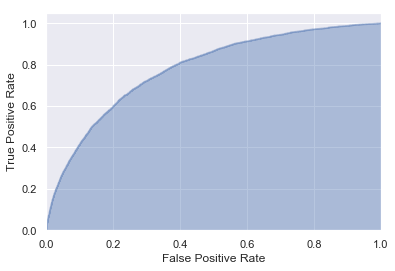

In [100]:
pd.Series(tpr, index=fpr).plot(kind="area", alpha=0.4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

### Optimal threshold

In [101]:
fpr = []
tpr = []
cost = []
thresh = []


ltn = []
ltp = []
lfn = []
lfp = []

cfp = 1
cfn = 10

for i in np.arange(0,1,0.001) : 
    threshold = i
    y_bin = y_prob_n >= threshold
    tn, fp, fn, tp = confusion_matrix(y_test_piped, y_bin).ravel()
    #print(tn, fp, fn, tp)
    fpr.append(fp/(fp+tn))
    tpr.append(tp/(tp+fn))
    cost.append(cfp * fp + cfn * fn)
    
    ltn.append(tn)
    ltp.append(tp)
    lfn.append(fn)
    lfp.append(fp)
    
    thresh.append(i)

In [102]:
cm = pd.DataFrame({"tn" : ltn,
                  "tp" : ltp,
                  "fn" : lfn,
                  "fp" : lfp}, index=np.arange(0,1,0.001))

In [103]:
cfp=1
cfn=10
cost = pd.DataFrame({"Coût total des FPs (FP = 1)" : cm["fp"] * cfp,
                     "Coût total des FNs (FN = 10)" : cm["fn"] * cfn})

In [104]:
accuracy = cm.divide(cm.sum(axis=1), axis=0)[["fp", "fn"]].sum(axis=1)
errors = cm.divide(cm.sum(axis=1), axis=0)[["fp", "fn"]]
errors.columns = ["Faux Positifs", "Faux Negatifs"]

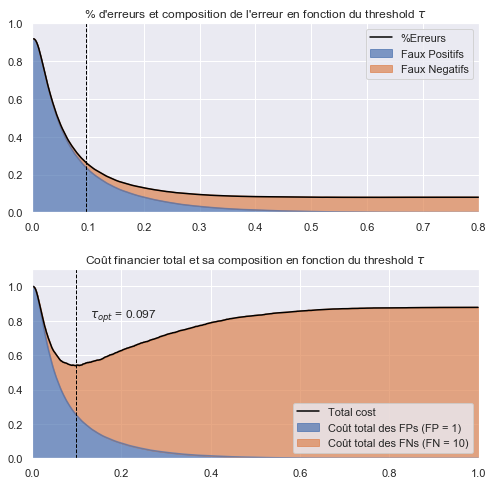

In [105]:
fig, ax = plt.subplots(2,1, figsize=(8,8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)

errors.plot(kind='area', stacked=True, alpha=0.7, ax=ax[0])
accuracy.plot(ax=ax[0], color="black", label="%Erreurs")
ax[0].axvline(x=cost.sum(axis=1).idxmin(), color="black", linestyle="--", lw=1)
ax[0].set_xlim(0,0.8)
ax[0].set_ylim(0,1)
#ax[0].set_title(r"% of Errors and its composition as a function of threshold $\tau$")
ax[0].set_title(r"% d'erreurs et composition de l'erreur en fonction du threshold $\tau$")
ax[0].legend()

(cost/cost.sum(axis=1).max()).plot(kind="area", stacked=True, alpha=0.7, ax=ax[1])
(cost.sum(axis=1)/cost.sum(axis=1).max()).plot(ax=ax[1], color="black", label="Total cost")
ax[1].axvline(x=cost.sum(axis=1).idxmin(), color="black", linestyle="--", lw=1)
ax[1].set_xlim(0,1)
ax[1].set_ylim(0,1.1)
ax[1].set_title(r"Coût financier total et sa composition en fonction du threshold $\tau$")
plt.text(x=0.13, y=0.82, s=r"$\tau_{opt}$ = " + str(cost.sum(axis=1).idxmin()))
ax[1].legend()

plt.show()


In [106]:
# calculate AUC
auc = roc_auc_score(y_test_piped, y_prob)
print('AUC: %.3f' % auc)

AUC: 0.780


# SHap Analysis

## Fitting the model on the big set

In [107]:
X_train = pipe.transform(X_train)

mon premier set (307507, 13)
mon second set (307507, 661)


In [108]:
y_train = y_train.loc[X_train.index]

In [109]:
print(X_train.shape, y_train.loc[X_train.index].shape)

(307507, 200) (307507,)


In [110]:
lgbm_model = lgb.LGBMClassifier(metric = "auc",
                                boosting_type = "gbdt",
                                colsample_bytree = 0.90,
                                num_leaves = 15,
                                max_depth = -1,
                                n_estimators = 100,
                                min_child_samples = 20, 
                                min_child_weight = 0.001,
                                reg_alpha = 0,
                                reg_lambda = 0,
                                subsample = 0.9,
                                verbose = -1,
                                num_threads = 4,
                                objective = "binary",
                                categorical_features = cat_idx,
                               )

In [111]:
lgbm_model.fit(X_train.astype(float), y_train)

LGBMClassifier(boosting_type='gbdt',
               categorical_features=[0, 1, 2, 3, 4, 5, 6, 7, 8],
               class_weight=None, colsample_bytree=0.9, importance_type='split',
               learning_rate=0.1, max_depth=-1, metric='auc',
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=15, num_threads=4,
               objective='binary', random_state=None, reg_alpha=0, reg_lambda=0,
               silent=True, subsample=0.9, subsample_for_bin=200000,
               subsample_freq=0, verbose=-1)

In [112]:
X_train_proba = lgbm_model.predict(X_train)

In [113]:
X_train_proba

array([0, 0, 0, ..., 0, 0, 0])

## Value to test

In [114]:
X_test = pipe.transform(X_test)

mon premier set (48744, 13)
mon second set (48744, 652)


In [115]:
trial = X_test.tail(1)
print("probabilities are :", lgbm_model.predict_proba(trial),
      "binary decision is :", lgbm_model.predict(trial))

probabilities are : [[0.6810932 0.3189068]] binary decision is : [0]


In [116]:
trial

,NAME_CONTRACT_TYPE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,WEEKDAY_APPR_PROCESS_START,FONDKAPREMONT_MODE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,...,CC_SK_DPD_DEF_MEAN,CC_SK_DPD_DEF_SUM,CC_SK_DPD_DEF_VAR,CC_NAME_CONTRACT_STATUS_Active_MIN,CC_NAME_CONTRACT_STATUS_Completed_MAX,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Demand_SUM,CC_NAME_CONTRACT_STATUS_Sent_proposal_MEAN,CC_NAME_CONTRACT_STATUS_Sent_proposal_VAR,CC_NAME_CONTRACT_STATUS_Signed_MIN
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
456250,0,7,6,4,5,0,0,1,1,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [117]:
import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(lgbm_model.booster_,
                               data=X_train.head(3000),
                               feature_dependence="interventional",
                               output="predict_proba",
                              )

Passing 3000 background samples may lead to slow runtimes. Consider using shap.sample(data, 100) to create a smaller background data set.


In [118]:
shap_values = explainer.shap_values(trial, check_additivity=True)

In [119]:
#visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0],
                trial, link="logit"
               )

In [120]:
new_vars = abs(pd.Series(shap_values[0], index=X_train.columns)).sort_values(ascending=False).head(20).index

In [121]:
abs(pd.Series(shap_values[0], index=X_train.columns)).sort_values(ascending=False).head(20)

EXT_SOURCE_3                        0.483806
CC_CNT_DRAWINGS_ATM_CURRENT_MEAN    0.165454
PAYMENT_RATE                        0.160157
CODE_GENDER                         0.150908
EXT_SOURCE_2                        0.139066
DAYS_EMPLOYED_PERC                  0.136026
EXT_SOURCE_1                        0.127516
INSTAL_DPD_MEAN                     0.105200
POS_MONTHS_BALANCE_SIZE             0.100038
APPROVED_CNT_PAYMENT_MEAN           0.090187
BURO_AMT_CREDIT_SUM_DEBT_MEAN       0.085394
NAME_EDUCATION_TYPE                 0.082194
APPROVED_AMT_ANNUITY_MEAN           0.080852
DAYS_BIRTH                          0.079496
CC_CNT_DRAWINGS_ATM_CURRENT_VAR     0.074152
AMT_GOODS_PRICE                     0.060526
CC_AMT_PAYMENT_TOTAL_CURRENT_SUM    0.050331
ACTIVE_MONTHS_BALANCE_SIZE_MEAN     0.049827
PREV_APP_CREDIT_PERC_MAX            0.049803
ACTIVE_AMT_CREDIT_SUM_DEBT_SUM      0.047491
dtype: float64

In [122]:
descri = ["", 
 "The mean of the number of drawings during previous loans",
 "Payment Rate of current application", #paymrate
 "", #code
 "", # ext2
 "Percentage of Days Employed since birth",
 "",
 "Mean day past due (DPD) on Installements", #instal dpd mean
 "Number of months reported in HomeCredit previous loan data",
 "Average of the number of payment on accepted loeans", #APPROVED_CNT_PAYMENT_MEAN
 "Mean sum of Debt along all the records",
 "",
 "Mean annuity on accepted loans",
 "",
 "Variance of amounts drawed at the ATM",
 "",
 "Total repaid sum",
 "Mean lenght of active loans",
 "Max percentage of good price on previous applications",
 "Sum of debt on active loans"] 

In [123]:
new_variables = pd.DataFrame({"Row" : new_vars, "Description" : descri}, columns=variables.columns)

219, j'en veux pas 239 y en a qui y sont déjà !

In [124]:
new_variables_filled = pd.concat([variables, new_variables], axis=0).drop_duplicates(subset=["Row"], keep="first")

In [125]:
new_variables_filled

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
5,8,application_{train|test}.csv,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
6,9,application_{train|test}.csv,CNT_CHILDREN,Number of children the client has,NaN
7,10,application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client,NaN
8,11,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,NaN
9,12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,NaN


In [126]:
new_variables_filled.to_csv("../data/input_data/new_variables.csv")

In [127]:
import os

In [128]:
new_variables_filled.to_csv('imhere')

## Explain the variables and its aggregation to understand the values

In [129]:
big_contrib = abs(pd.Series(shap_values[0], index=X_train.columns)).sort_values(ascending=False).head(5)

In [130]:
big_contrib.index

Index(['EXT_SOURCE_3', 'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN', 'PAYMENT_RATE',
       'CODE_GENDER', 'EXT_SOURCE_2'],
      dtype='object')

 99%|===================| 992/1000 [01:52<00:00]        

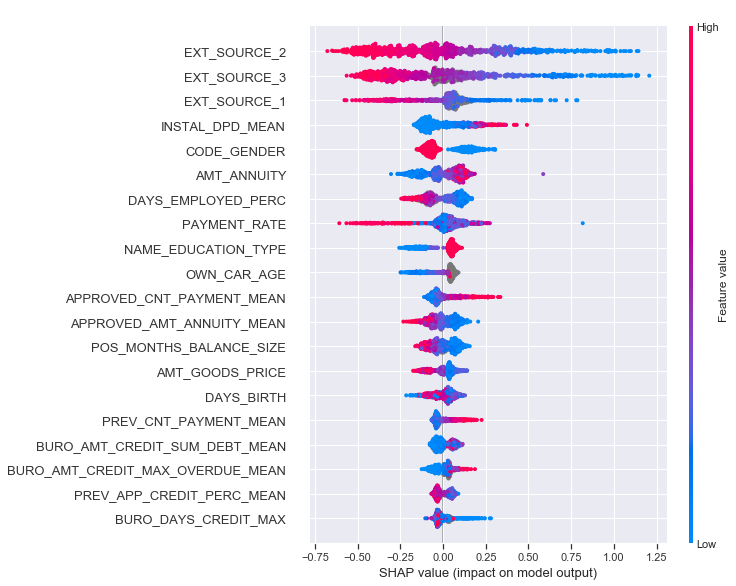

In [131]:
shap_values = explainer.shap_values(X_train.head(1000), check_additivity=True)
shap.summary_plot(shap_values, X_train.head(1000), feature_names=X_train.columns)

# Dump Materials

## Active Components

In [132]:
from joblib import dump, load

In [133]:
dump(pipe, "../model/preprocessor.joblib")

['../model/preprocessor.joblib']

In [134]:
dump(lgbm_model, "../model/estimator.joblib")

['../model/estimator.joblib']

In [137]:
preprocessor_reloaded = load("../model/preprocessor.joblib")

In [152]:
preprocessor_reloaded.named_steps['ColumnTransformer'].transformer_list[0][1].named_steps["dtype"].cat_feat

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

## Passive Components

In [114]:
bb_feat.to_csv("../data/output_data/bb_feat.csv")

In [116]:
pa_feat.to_csv("../data/output_data/pa_feat.csv")

In [118]:
pos_feat.to_csv("../data/output_data/pos_feat.csv")

In [120]:
ins_feat.to_csv("../data/output_data/ins_feat.csv")

In [122]:
ccb_feat.to_csv("../data/output_data/ccb_feat.csv")

In [126]:
ms.to_csv("../data/output_data/ms.csv")

Those three set are the full sets

In [127]:
X_train.to_csv("../data/output_data/X_train.csv")

In [128]:
y_train.rename("y_train").to_csv("../data/output_data/y_train.csv")

In [129]:
X_test.to_csv("../data/output_data/X_test.csv")

# Get Variables descriptions of OutputSet

In [328]:
variables = variables.set_index("Unnamed: 0")

In [333]:
variables.head()

,Table,Row,Description,Special
Unnamed: 0,,,,
1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


In [329]:
new_names = pd.DataFrame({"Row" : X_train.columns})

In [331]:
all_variables = variables.merge(new_names, left_on="Row", right_on = "Row", how="outer")

In [338]:
all_variables.sample(10)

,Table,Row,Description,Special
37,application_{train|test}.csv,FLAG_PHONE,"Did client provide home phone (1=YES, 0=NO)",NaN
307,NaN,PREV_PRODUCT_COMBINATION_POS_industry_without_...,NaN,NaN
160,POS_CASH_balance.csv,CNT_INSTALMENT_FUTURE,Installments left to pay on the previous credit,NaN
168,credit_card_balance.csv,AMT_BALANCE,Balance during the month of previous credit,NaN
240,NaN,ACTIVE_AMT_CREDIT_SUM_DEBT_SUM,NaN,NaN
372,NaN,CC_NAME_CONTRACT_STATUS_Completed_MAX,NaN,NaN
126,application_{train|test}.csv,FLAG_DOCUMENT_19,Did client provide document 19,NaN
262,NaN,PREV_NAME_CASH_LOAN_PURPOSE_Building_a_house_o...,NaN,NaN
20,previous_application.csv,AMT_GOODS_PRICE,Goods price of good that client asked for (if ...,NaN
24,application_{train|test}.csv,NAME_EDUCATION_TYPE,Level of highest education the client achieved,NaN


In [369]:
def create_description(row) : 
    feature_name = row["Row"]
    description = row["Description"]
    if type(description) == str : 
        print(description)
    else :
        if feature_name.split("_")[0] == CC :
            table = "from table Credit Card"
            row["Description"] = "new descr"
        
    return row

In [370]:
variables2 = all_variables.copy()

In [371]:
variables2.apply(lambda x : create_description(x), axis=1)

ID of loan in our sample
ID of loan in our sample
ID of loan in our sample - one loan in our sample can have 0,1,2 or more related previous credits in credit bureau 
ID of loan in our sample
ID of loan in our sample
ID of loan in our sample
ID of loan in our sample
Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)
Identification if loan is cash or revolving
Contract product type (Cash loan, consumer loan [POS] ,...) of the previous application
Gender of the client
Flag if the client owns a car
Flag if client owns a house or flat
Number of children the client has
Income of the client
Credit amount of the loan
Final credit amount on the previous application. This differs from AMT_APPLICATION in a way that the AMT_APPLICATION is the amount for which the client initially applied for, but during our approval process he could have received different amount

Did client provide document 18
Did client provide document 19
Did client provide document 20
Did client provide document 21
Number of enquiries to Credit Bureau about the client one hour before application
Number of enquiries to Credit Bureau about the client one day before application (excluding one hour before application)
Number of enquiries to Credit Bureau about the client one week before application (excluding one day before application)
Number of enquiries to Credit Bureau about the client one month before application (excluding one week before application)
Number of enquiries to Credit Bureau about the client 3 month before application (excluding one month before application)
Number of enquiries to Credit Bureau about the client one day year (excluding last 3 months before application)
Recoded ID of previous Credit Bureau credit related to our loan (unique coding for each loan application)
Recoded ID of Credit Bureau credit (unique coding for each application) - use this to joi

,Table,Row,Description,Special
0,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,bureau.csv,SK_ID_CURR,ID of loan in our sample - one loan in our sam...,hashed
2,POS_CASH_balance.csv,SK_ID_CURR,ID of loan in our sample,NaN
3,credit_card_balance.csv,SK_ID_CURR,ID of loan in our sample,hashed
4,previous_application.csv,SK_ID_CURR,ID of loan in our sample,hashed
5,installments_payments.csv,SK_ID_CURR,ID of loan in our sample,hashed
6,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
7,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
8,previous_application.csv,NAME_CONTRACT_TYPE,"Contract product type (Cash loan, consumer loa...",NaN
9,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN


In [154]:
data= pd.read_csv("../data/input_data/application_train.csv")


In [156]:
var = "OWN_CAR_AGE"

max_var = data[var].max()
min_var = data[var].min()       
        
x = pd.cut(data[var], bins=np.arange(min_var, max_var, 20))
y = data.groupby(x)["TARGET"].mean()

y
# plt.bar(x=x, height=y)

OWN_CAR_AGE
(0.0, 20.0]     0.069512
(20.0, 40.0]    0.096453
(40.0, 60.0]    0.085561
(60.0, 80.0]    0.083608
Name: TARGET, dtype: float64

In [183]:
dtypes_list = pd.read_csv("../data/output_data/X_test.csv").dtypes

In [184]:
dtypes_list.to_csv("./dtypes.csv")